# Introduction
In this notebook, we will  implement a Convolutional Neural Network (CNN) to classify [Chest X-Ray Images (Pneumonia)](http://) dataset. This dataset consists of X-ray images that are labeled into two categories: "Normal" and "Pneumonia."

Our goal is to define a CNN model to perform binary classification and then evaluate the model's performance. Then, we will apply transfer learning strategy using several pre-trained models, fine-tune them, compare their performance with my model's, and integrate them to achieve the best performance.

Finally, we will explore the final model interpretability through explainable airtifical intelligence (XAI) techniques to explain and understand the model predictions

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.python.framework.errors_impl import NotFoundError, InvalidArgumentError
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display, clear_output, HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

tf.get_logger().setLevel('ERROR')

E0000 00:00:1746974558.669099      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


# TPU / GPU Strategy
This block detects and initializes a TPU if available, otherwise defaults to standard strategy.

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU initialized successfully.")
    print("TPU device:", tpu.master())
    print("Number of replicas:", strategy.num_replicas_in_sync)
except (NotFoundError, InvalidArgumentError, ValueError) as e:
    print("TPU not found or failed to initialize. Falling back to CPU/GPU.")
    strategy = tf.distribute.get_strategy()

print("Strategy type:", type(strategy).__name__)
print("TensorFlow version:", tf.__version__)

I0000 00:00:1746974583.051570      74 service.cc:148] XLA service 0x5815a9737820 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746974583.051615      74 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1746974583.051619      74 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1746974583.051622      74 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8


I0000 00:00:1746974583.051625      74 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1746974583.051628      74 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1746974583.051631      74 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1746974583.051633      74 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1746974583.051636      74 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


TPU initialized successfully.
TPU device: 
Number of replicas: 8
Strategy type: TPUStrategyV2
TensorFlow version: 2.18.0


# Define Constants

Before diving into loading our dataset, we define some constants, including the dataset pathway, image size, the number of epochs, and so on.

In [3]:
DS_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray'
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = [224, 224]
EPOCHS = 100
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ]

# Load Data and Analysis

We load images from the dataset, and see what's going on there.

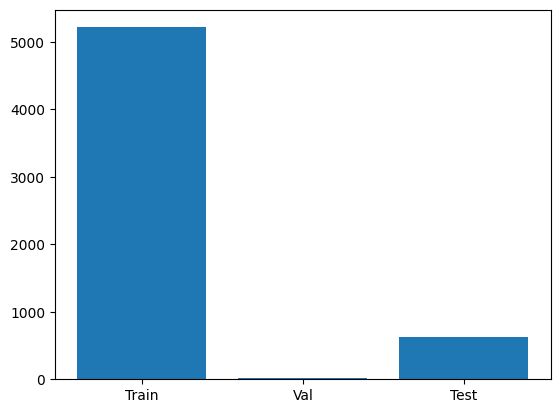

Number of images in the training set: 5216
Number of images in the validation set: 16
Number of images in the test set: 624


In [4]:
train_files = tf.io.gfile.glob(str(DS_PATH + '/train/*/*'))
val_files = tf.io.gfile.glob(str(DS_PATH + '/val/*/*'))
test_files = tf.io.gfile.glob(str(DS_PATH + '/test/*/*'))


plt.bar(
    x=['Train', 'Val', 'Test'],
    height=[len(train_files),len(val_files),len(test_files)])
plt.show()
print(f"Number of images in the training set: {len(train_files)}")
print(f"Number of images in the validation set: {len(val_files)}")
print(f"Number of images in the test set: {len(test_files)}")

It's clear that the number of images in each folder is imbalanced. In particular, the validation set contains less than 1% of the total dataset, which is insufficient.

To address this, we reorganize the dataset using a 70-15-15 split — allocating 70% of the images to the training set, and 15% each to the validation and test sets.

# Splitting Data

As mentioned earlier, we will split the dataset using a 70-15-15 ratio.

In [5]:
all_files = train_files + val_files + test_files

labels = [1 if "PNEUMONIA" in os.path.dirname(f) else 0 for f in all_files]

normal_count = len([labels for label in labels if label == 0])
pneumonia_count = len([labels for label in labels if label == 1])

print("NORMAL: " + str(normal_count))
print("PNEUMONIA: " + str(pneumonia_count))


train_val_names, test_names, train_val_labels, test_labels = train_test_split(
    all_files, labels, test_size=0.15, stratify=labels)
train_names, val_names, train_labels, val_labels = train_test_split(
    train_val_names, train_val_labels, test_size=0.176, stratify=train_val_labels)

print(f"Number of images in the new training set: {len(train_names)}")
print(f"Number of images in the new validation set: {len(val_names)}")
print(f"Number of images in the new test set: {len(test_names)}")

NORMAL: 1583
PNEUMONIA: 4273


Number of images in the new training set: 4101
Number of images in the new validation set: 876
Number of images in the new test set: 879


# Addressing the imbalance between normal and pneumonia images

The number of images diagnosed with pneumonia is approximately three times greater than that of normal images. This class imbalance can introduce a bias toward predicting pneumonia. To address this, we assign a higher weight to the class with fewer images—here, the normal class—using class weighting

In [6]:
train_normal = sum(1 for l in train_labels if l == 0)
train_pneumonia = sum(1 for l in train_labels if l == 1)
class_weight = {
    0: len(train_labels)/(2*train_normal),
    1: len(train_labels)/(2*train_pneumonia)
}

print(class_weight)

{0: 1.8506317689530687, 1: 0.6850985633144002}


In the next step, we define 4 functions to prepare our image data. First, `get_label` extracts the label of a given image from its path, returning 1 for pneumonia images and 0 for normal images. The `decode_img` uses a technique called *min-max normalization* and then resizes images to a predefined `IMG_SIZE`. For TensorFlow, it is easier to deal with images whose RGB values are between 0 and 1 rather than 0 to 255, which is why we apply *min-max normalization*. The `process_path` function combines these operations, taking a file path and returning both the processed image and its label. Finally, `build_dataset` creates an optimized TensorFlow `tf.data.Dataset` with options for caching (to improve performance), shuffling (for training data), batching, and prefetching to maximize throughput during model training.

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32)
  img = img / 255
  img = tf.image.resize(img, IMG_SIZE)
  return img

def process_path(file_path):
  label = get_label(file_path)
  img = decode_img(tf.io.read_file(file_path))
  return img, label


def build_dataset(dataset, cache=True, training=False, shuffle_size=1000):
    ds = tf.data.Dataset.from_tensor_slices(dataset)
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    if training:
        ds = ds.shuffle(shuffle_size).repeat()
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds
    

In [8]:
train_ds = build_dataset(train_names, training=True)
val_ds = build_dataset(val_names)
test_ds = build_dataset(test_names)

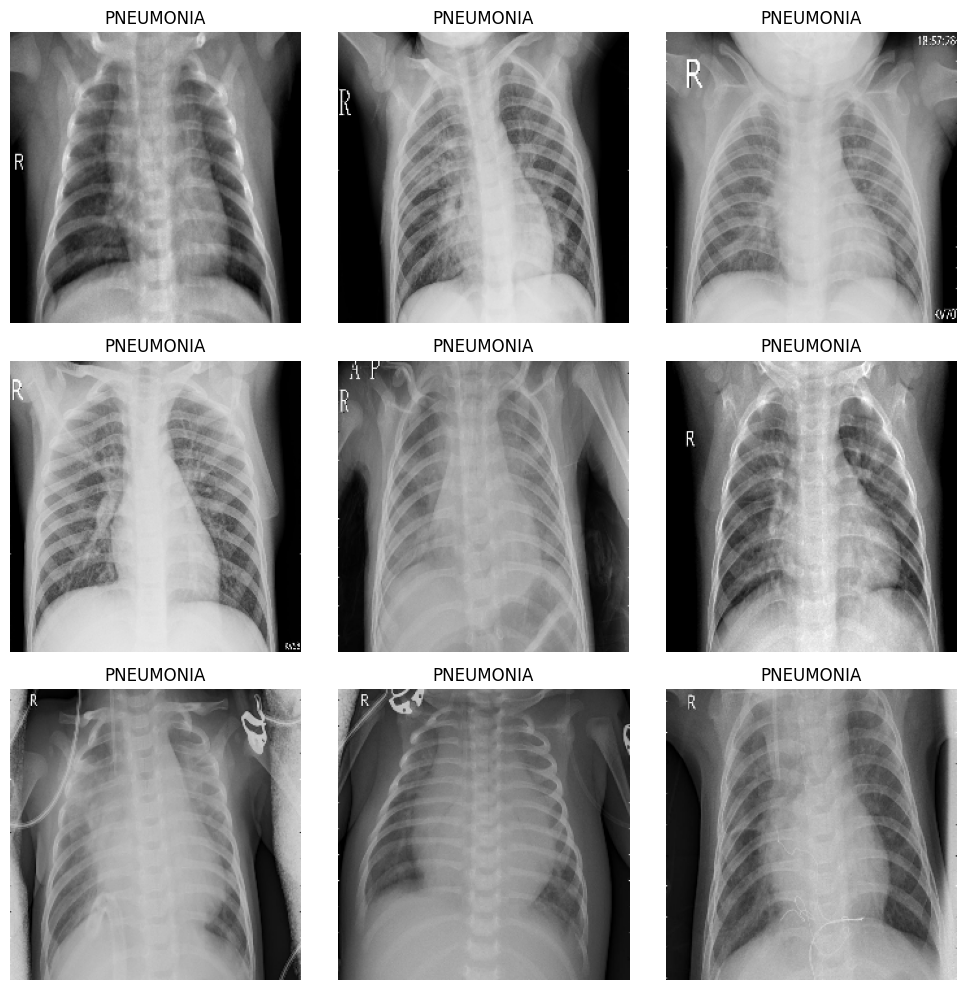

In [9]:
def plot_img_with_label(ax, image, label):
    ax.imshow(image)
    title = "PNEUMONIA" if label else "NORMAL"
    ax.set_title(title)
    ax.axis("off")

img_batch, label_batch = next(iter(train_ds))


def display_img_batch(img, label, iter=9, size=(3, 3)):
    fig, axes = plt.subplots(size[0], size[1], figsize=(10, 10))
    axes = axes.flatten()
    for i in range(iter):
        plot_img_with_label(axes[i], img[i], label[i])
    plt.tight_layout()  
    plt.show()

display_img_batch(img_batch, label_batch)

# Define Model Architecture

Due to limited resources and the need to train a model from scratch, I can't use large architectures and choose a simpler model instead. My CNN architecture is inspired by the integration of concepts from [this article](https://www.nature.com/articles/s41598-025-85874-7) and the information provided on [this page](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays/notebook). 

The architecture begins with an input layer followed by a series of convolutional blocks. Each block consists of three layers: a Conv2D layer, a MaxPooling2D layer, and a BatchNormalization layer. The blocks use different kernel sizes (11, 5, and 3), which enhances the model's ability to extract diverse features. This approach, derived from the article, helps prevent reduced diversity that might result from using an identical kernel size. By incorporating varying kernel sizes, the model is able to extract both broad and fine-grained features—larger kernels capture more general patterns, while smaller ones are better suited for detecting finer details like lines. Following this, the model includes two separable convolutional blocks, each consisting of three layers —a SeparableConv2D, a MaxPooling2D, and a Batch Normalization layer. The use of separable convolutions improves computational efficiency by decomposing the operation into depthwise and pointwise convolutions. After that, a Dropout layer is added to decrease overfitting, followed by a Flatten layer. The model then includes two fully connected layers with 512 and 256 units, respectively, allowing for a gradual reduction in feature complexity. This gradual reduction of neurons helps the model learn more meaningful representations and further prevents overfitting. Finally, for binary classification, an output layer with a sigmoid activation function is used. The sigmoid function outputs values between 0 and 1, which represents possibility, where values closer to 0 indicate normal cases, and values closer to 1 indicate pneumonia. A threshold of 0.5 is applied to determine classification results.

In [10]:
def conv2dsep_block(filters, kernel_size, pad):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, kernel_size, activation='relu', padding=pad),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.BatchNormalization(),
  ])
  return block

def conv2d_block(filters, kernel_size, pad):
  block = tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding=pad),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.BatchNormalization(),
  ])

  return block

def dense_block(filters):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(filters, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.25),
  ])

  return block

In [11]:
def model():
  cnn = tf.keras.Sequential([
      tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

      conv2d_block(32, 3, 'same'),
      conv2d_block(32, 5, 'same'),
      conv2d_block(32, 11, 'same'),

      conv2dsep_block(64, 3, 'valid'),
      conv2dsep_block(128, 3, 'valid'),
      tf.keras.layers.Dropout(0.25),

      tf.keras.layers.Flatten(),
      dense_block(512),
      dense_block(256),

      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
  cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=metrics)
  return cnn

In [12]:
with strategy.scope():
    model = model()

model.summary()

I0000 00:00:1746974591.910457      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 112, 112, 32)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 32)     │       124,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 13, 13, 64)     │         2,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 5, 5, 128)      │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 512)            │     1,640,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256)            │       132,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,936,481 (7.39 MB)

 Trainable params: 1,934,369 (7.38 MB)

 Non-trainable params: 2,112 (8.25 KB)

Before training the model, we define a class called `PlotLossesCallback` to visualize the training and validation losses in real time. This allows us to monitor the model's performance during training.

In [13]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
  def __init__(self, name):
    self.name = name
    self.losses = [None]
    self.val_losses = [None]
    self.fig = plt.figure()
        
  def on_epoch_end(self, epoch, logs=None):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.clf()

    plt.plot(self.losses, label='Training Loss')
    plt.plot(self.val_losses, label='Validation Loss')
    plt.title(self.name + ' Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
        
    plt.legend()
    plt.grid(True)
    plt.show()        

# Train the model

Next, we train our model using the `fit()` function. We pass `plot_callback`, an instance of the `PlotLossesCallback` class, to plot the losses in real time.



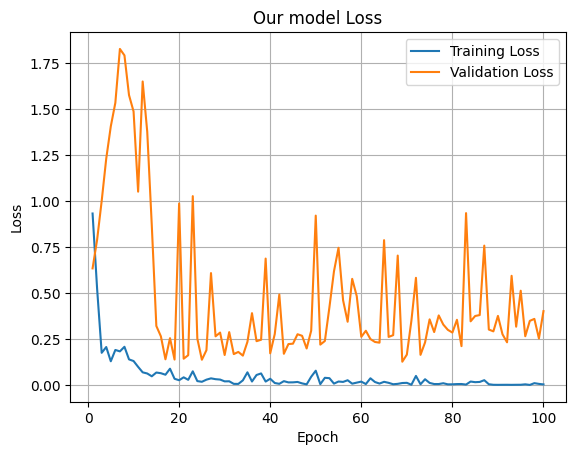

In [14]:
model_plotcallback = PlotLossesCallback('Our model')
history = []
history.append(model.fit(train_ds,
                    steps_per_epoch=len(train_names) // BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_data=val_ds,
                    validation_steps=len(val_names) // BATCH_SIZE,
                    callbacks=[model_plotcallback], verbose=0))

# Evaluation and Plotting

In this step, we define functions to return several metrics to evaluate our model on test dataset, these metrics are as shown in the table below. Additionally we plot the confusion matrix.

|   Metric  |                                                                        Formula                                                                       | Detail                                                                                                              |
| :-------: | :--------------------------------------------------------------------------------------------------------------------------------------------------: | :------------------------------------------------------------------------------------------------------------------ |
|  Accuracy |                                                                 $\frac{TP+TN}{P+N}$                                                                | General performance; however, can be misleading in situations like data imbalance                                   |
| Precision |                                                                 $\frac{TP}{TP+FP}$                                                                 | The proportion of predicted positive instances that are actually positive, reflects quality of positive predictions |
|   Recall  |                                                                 $\frac{TP}{TP+FN}$                                                                 | The proportion of positive instances that are identified by the model, important for false negative identification  |
|    AUC    | The area under the ROC curve, which plots the relationship between the true positive rate (or recall) and false positive rate ($\frac{FP}{FP+TN}$) | Evaluate the model performance across different thresholds                                                          |
|  F1 Score |                                                   $2×\frac{Precision ×Recall}{Precision+Recall}$                                                   | A Balanced metric of precision and recall                                                                           |


In [15]:
metrics_history = []

def evaluate_test_set(model):
  loss, accuracy, precision, recall, auc = model.evaluate(test_ds, verbose=0)
  f1 = 2 * (precision * recall) / (precision + recall)
  return {'Loss':loss, 'Accuracy':accuracy, 'Precision':precision,
          'Recall':recall, 'AUC': auc, 'F1-Score': f1}

def print_metrics(metrics):
  headers = list(metrics.keys())
  row = list(metrics.values())
  tab = tabulate([row], headers=headers, tablefmt="unsafehtml")
  display(HTML(tab))
  return 

def plot_confusion_matrix(model):
  y_pred = model.predict(test_ds,verbose=0)
  y_pred_classes = (y_pred > 0.5).astype(int)
  y_true = []
  for image, label in test_ds:
    y_true.extend(label.numpy())
  cm = confusion_matrix(y_true, y_pred_classes)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Predicted 0', 'Predicted 1'],
              yticklabels=['True 0', 'True 1'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()


def eval_and_plot_cf(model):
  metrics = evaluate_test_set(model)
  print_metrics(metrics)
  plot_confusion_matrix(model)

  metrics_history.append(metrics)

# Experiments

We conducte five experiments after training our model, including adding *early stopping* and *checkpoints*. Early stopping prevents overfitting when the model’s performance on the validation set (by monitoring loss of the validation set) stops improving. Therefore, it saves time and resources. Checkpoints save the model’s weight during training at intervals, allowing me to restore the best-performing version. Then, we further optimize the model through four steps of learning rate adjustment to enhance performance. 

## 1. Using earlystopping and checkpoint

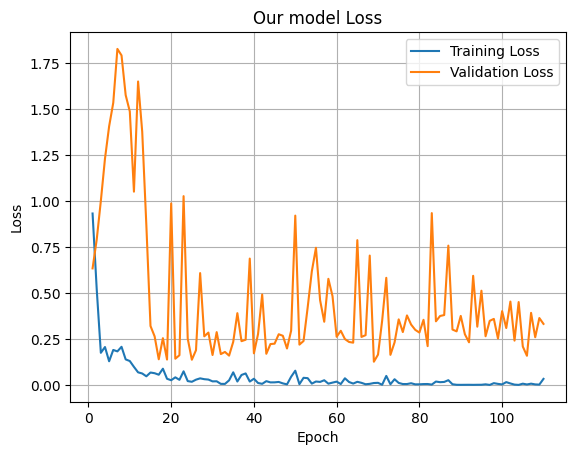

In [16]:
early_stopping_model = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True)

checkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    'pneumonia_classification_model.keras', monitor='val_loss', save_best_only=True, verbose = 1)

history.append(model.fit(train_ds,
                    steps_per_epoch=len(train_names) // BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_data=val_ds,
                    validation_steps=len(val_names) // BATCH_SIZE,
                    callbacks=[early_stopping_model, checkpoint_model, model_plotcallback],
                    verbose=0))


## 2. Adjusting Learning Rate: 1st time

In [17]:
def lr_scheduler(i_lr, steps, rate):
  lr_exponential_decay = ExponentialDecay(
    initial_learning_rate=i_lr,
    decay_steps=steps,
    decay_rate=rate)

  def lr_schedule(epoch):
      lr = lr_exponential_decay(epoch)
      return float(lr.numpy())

  return tf.keras.callbacks.LearningRateScheduler(lr_schedule)

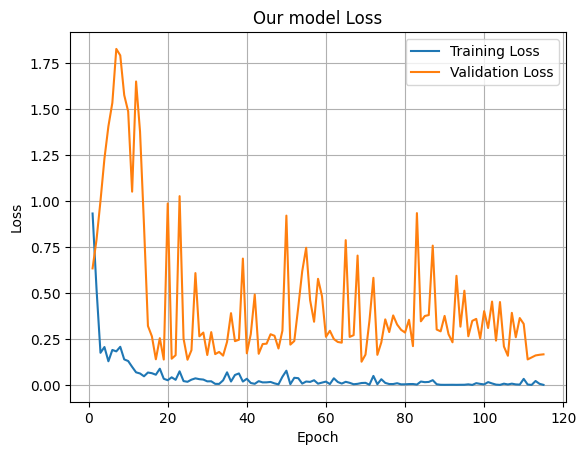

In [18]:
scheduler = lr_scheduler(0.0001, 10, 0.00001)
history.append(model.fit(train_ds,
                    steps_per_epoch=len(train_names) // BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_data=val_ds,
                    validation_steps=len(val_names) // BATCH_SIZE,
                    callbacks=[early_stopping_model, checkpoint_model, model_plotcallback, scheduler],
                    verbose=0))

## 3. Adjusting learning rate: 2nd time

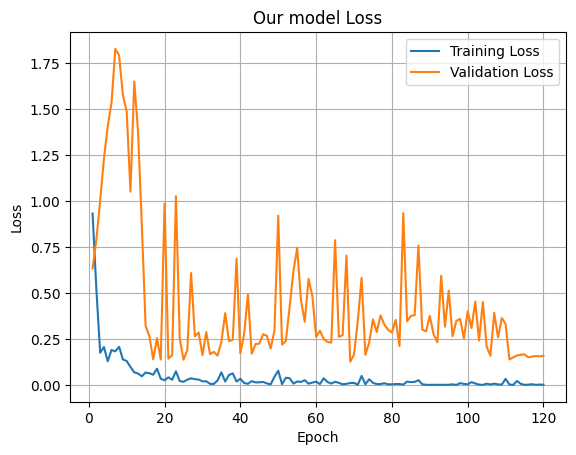

In [19]:
scheduler = lr_scheduler(0.00005, 10, 0.00001)
history.append(model.fit(train_ds,
                    steps_per_epoch=len(train_names) // BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_data=val_ds,
                    validation_steps=len(val_names) // BATCH_SIZE,
                    callbacks=[early_stopping_model, checkpoint_model, model_plotcallback, scheduler],
                    verbose=0))

## 4. Adjusting learning rate: 3rd time

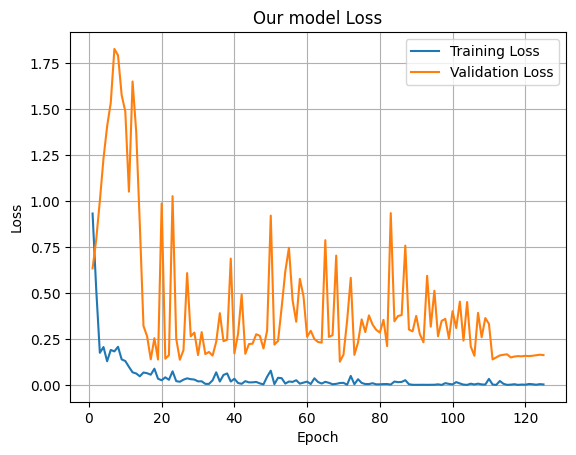

In [20]:
scheduler = lr_scheduler(0.000075, 5, 0.000005)
history.append(model.fit(train_ds,
                    steps_per_epoch=len(train_names) // BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_data=val_ds,
                    validation_steps=len(val_names) // BATCH_SIZE,
                    callbacks=[early_stopping_model, checkpoint_model, model_plotcallback, scheduler],
                    verbose=0))

## 5. Adjusting Learning Rate: 4th time

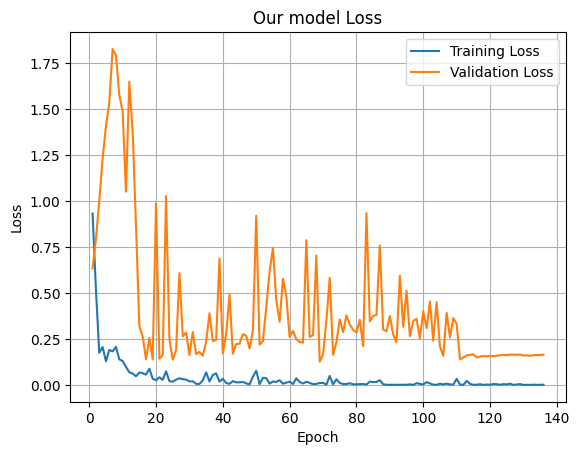

In [21]:
scheduler = lr_scheduler(0.00005, 5, 0.0000005)
history.append(model.fit(train_ds,
                    steps_per_epoch=len(train_names) // BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_data=val_ds,
                    validation_steps=len(val_names) // BATCH_SIZE,
                    callbacks=[early_stopping_model, checkpoint_model, model_plotcallback, scheduler],
                    verbose=0))

Now, we evaluate the performance of our model on the test dataset using a confusion matrix and other metrics

I0000 00:00:1746975118.037717     832 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(12286010511682246625), session_name()


I0000 00:00:1746975133.773809     832 tpu_compile_op_common.cc:245] Compilation of 12286010511682246625 with session name  took 15.736016503s and succeeded


I0000 00:00:1746975133.777675     832 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(12286010511682246625), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16102742337181741330", property.function_library_fingerprint = 4512183800267748331, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "14,224,224,3,;14,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1746975133.777710     832 tpu_compilation_cache_interface.cc:542] After adding entry for key 12286010511682246625 with session_name  cache is 3 entries (56427004 bytes),  marked for eviction 0 entries (0 bytes).


Loss,Accuracy,Precision,Recall,AUC,F1-Score
0.0641107,0.975368,0.988647,0.980056,0.99584,0.984333


I0000 00:00:1746975135.443388      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2221644647748954924


E0000 00:00:1746975135.465658      74 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_7_1/dense_2_1/Add/ReadVariableOp.


I0000 00:00:1746975135.539983     804 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9546251001505372750), session_name()


I0000 00:00:1746975150.449685     804 tpu_compile_op_common.cc:245] Compilation of 9546251001505372750 with session name  took 14.909630522s and succeeded


I0000 00:00:1746975150.451940     804 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9546251001505372750), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2221644647748954924", property.function_library_fingerprint = 5782839511989802451, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1746975150.451986     804 tpu_compilation_cache_interface.cc:542] After adding entry for key 9546251001505372750 with session_name  cache is 4 entries (61877443 bytes),  marked for eviction 0 entries (0 bytes).


I0000 00:00:1746975151.746828      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5175364714650174676


I0000 00:00:1746975151.959798     832 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(10769206837982362699), session_name()


I0000 00:00:1746975166.510042     832 tpu_compile_op_common.cc:245] Compilation of 10769206837982362699 with session name  took 14.550200264s and succeeded


I0000 00:00:1746975166.512332     832 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(10769206837982362699), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_5175364714650174676", property.function_library_fingerprint = 15703310798395676176, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "14,224,224,3,;14,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1746975166.512364     832 tpu_compilation_cache_interface.cc:542] After adding entry for key 10769206837982362699 with session_name  cache is 5 entries (67381114 bytes),  marked for eviction 0 entries (0 bytes).


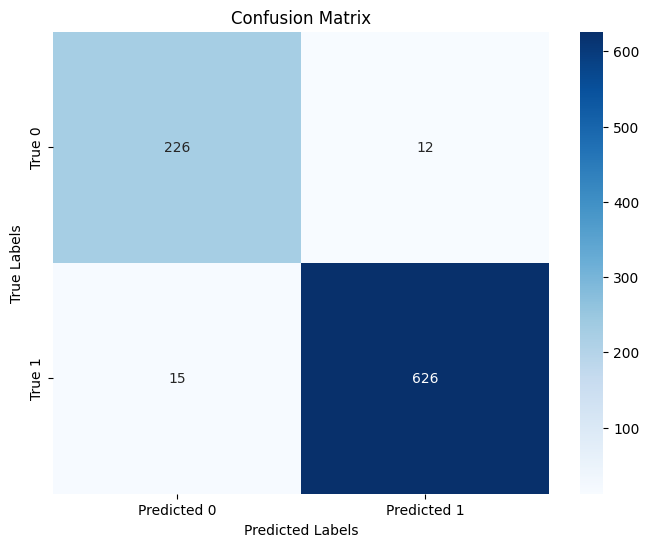

In [22]:
eval_and_plot_cf(model)

# Transfer learning

This step involves an approach that combines the initial layers of a pre-trained complex model with the final layers of our own model. Compared to training from scratch, this method is faster because feature extraction by the early layers has already been learned. We use ResNet50 and DenseNet121, initially freezing their layers, and then combine them with the final layers of our model.

## Model Architecture

As mentioned earlier, the transfer learning models consist of a base model (ResNet50 or DenseNet121) followed by the last four layers of our model.

In [23]:
def build_tl_model(base_model):
    base_model.trainable = False
    return tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [24]:
with strategy.scope():
    resnet_model = build_tl_model(ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    densenet_model = build_tl_model(DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))

    metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
    resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    densenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

       0/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

   49152/94765736 ━━━━━━━━━━━━━━━━━━━━ 2:49 2us/step

   81920/94765736 ━━━━━━━━━━━━━━━━━━━━ 3:21 2us/step

  950272/94765736 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step 

 1474560/94765736 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 2383872/94765736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 3661824/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 

 5423104/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 7618560/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 9895936/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

12312576/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

14860288/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

17547264/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

19972096/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

22528000/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

25255936/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

27623424/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

30162944/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

32866304/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

35266560/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

37822464/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

40542208/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

42893312/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

45441024/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

48152576/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

50536448/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

53084160/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

55771136/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

58171392/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

60710912/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

63225856/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

65806336/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

68345856/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

70901760/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

73441280/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

75988992/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

78536704/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

81076224/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

83632128/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

86171648/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

88711168/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

91258880/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

93593600/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


       0/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

   49152/29084464 ━━━━━━━━━━━━━━━━━━━━ 1:05 2us/step

   81920/29084464 ━━━━━━━━━━━━━━━━━━━━ 1:12 3us/step

  163840/29084464 ━━━━━━━━━━━━━━━━━━━━ 47s 2us/step 

  229376/29084464 ━━━━━━━━━━━━━━━━━━━━ 39s 1us/step

  327680/29084464 ━━━━━━━━━━━━━━━━━━━━ 32s 1us/step

  507904/29084464 ━━━━━━━━━━━━━━━━━━━━ 23s 1us/step

  704512/29084464 ━━━━━━━━━━━━━━━━━━━━ 19s 1us/step

 1032192/29084464 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step

 1507328/29084464 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 2220032/29084464 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step 

 3284992/29084464 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 4816896/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 7192576/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 8904704/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

11853824/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

13582336/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

16556032/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

19349504/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

20979712/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

25075712/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

28884992/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Here, we present the architecture of our transfer learning model based on ResNet50.

In [25]:
resnet_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

And here we can see our model's architecture based on DenseNet121.

In [26]:
densenet_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,693,889 (29.35 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

This is the training step. Each model is trained separately. As before, we evaluate both models' performance and plot their confusion matrices.

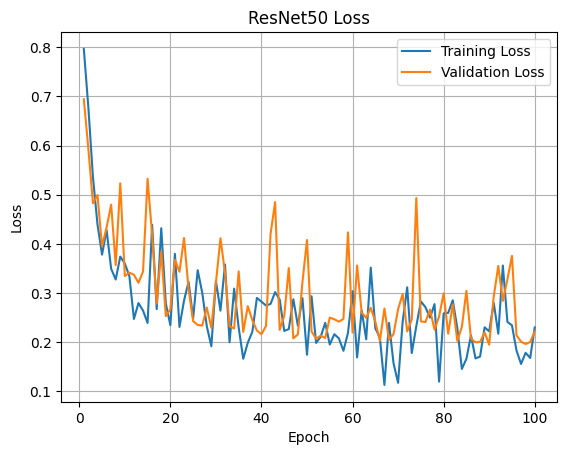

In [27]:
resnet_plotcallback = PlotLossesCallback('ResNet50')
resnet_history = resnet_model.fit(train_ds,
                    steps_per_epoch=len(train_names) // BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_data=val_ds,
                    validation_steps=len(val_names) // BATCH_SIZE,
                    callbacks=[resnet_plotcallback],
                    verbose=0)


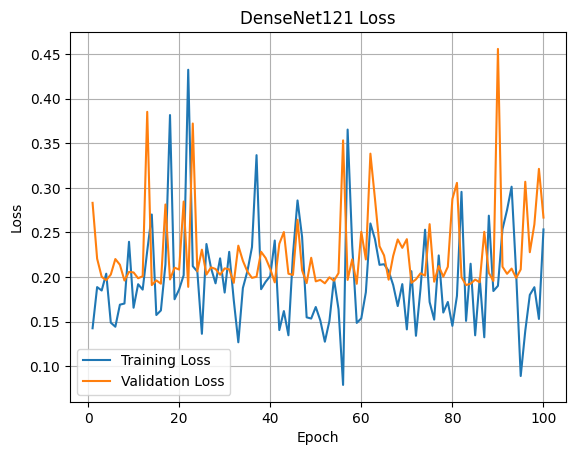

In [28]:
densenet_plotcallback = PlotLossesCallback('DenseNet121')

densenet_history = resnet_model.fit(train_ds,
                    steps_per_epoch=len(train_names) // BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_data=val_ds,
                    validation_steps=len(val_names) // BATCH_SIZE,
                    callbacks=[densenet_plotcallback],
                    verbose=0)


To decide which model performed better on the validation dataset, we plot the loss, accuracy, precision, recall, and AUC of both models side by side. The model with better overall performance will be selected.

In [29]:

def plot_metrics_tl(histories, names):
  metrics = ['auc', 'recall', 'precision', 'accuracy', 'loss']
  fig, axs = plt.subplots(1, len(metrics), figsize=(15,3))
    
  for n, met in enumerate(metrics):
    for hist, name in zip(histories, names):
      metric = hist.history["val_" + met]
      axs[n].plot(metric, label=name)
      axs[n].set_title(f'{metrics[n]}')
      axs[n].set_xlabel('Epoch')
      axs[n].set_ylabel(met)
      axs[n].legend()

  plt.tight_layout()
  plt.show()

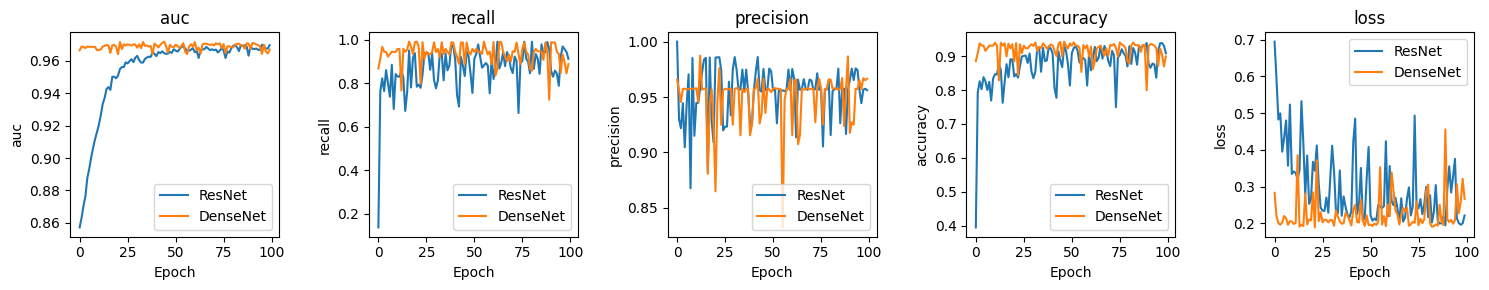

In [30]:
plot_metrics_tl([resnet_history, densenet_history], ['ResNet', 'DenseNet'])

In [31]:
def comparison_table(histories, names):
  metrics = ['auc', 'recall', 'precision', 'accuracy', 'loss']
  columns = {key: [hist.history.get(key)[-1] for hist in histories] for key in metrics}

  best_per_column = {
    key: min(values) if key.lower() == 'loss' else max(values)
    for key, values in columns.items()
  }

  rows = []
  for i, hist in enumerate(histories):
    row = [names[i]]

    for metric in metrics:
      last_epoch_value = hist.history.get(metric, [None])[-1]
      if last_epoch_value == best_per_column[metric]:
        row.append(f'<span style="color:#5DFF35;">{round(last_epoch_value,8)}</span>')
      else:
        row.append(round(last_epoch_value,8))
    rows.append(row)
  headers = ['Model/Metric'] + metrics
      
  return HTML(tabulate(rows, headers=headers, tablefmt='unsafehtml'))
    

In [32]:
comparison_table([resnet_history, densenet_history],
                       ['ResNet', 'DenseNet'])

Model/Metric,auc,recall,precision,accuracy,loss
ResNet,0.97055,0.90731585,0.93692535,0.89216059,0.229921
DenseNet,0.98590255,0.83939147,0.99922848,0.87620771,0.25335675


## Fine-Tuning the Model

ResNet50 outperformed DenseNet121 in 4 out of 5 metrics, including loss and AUC. So, ResNet50 was overall better model in this task. To further optimize its performance, we unfreeze the remaining layers so the model can better adapt to our dataset. We also use `CheckPoint` and `EarlyStopping` to further improve the results and training efficiency.

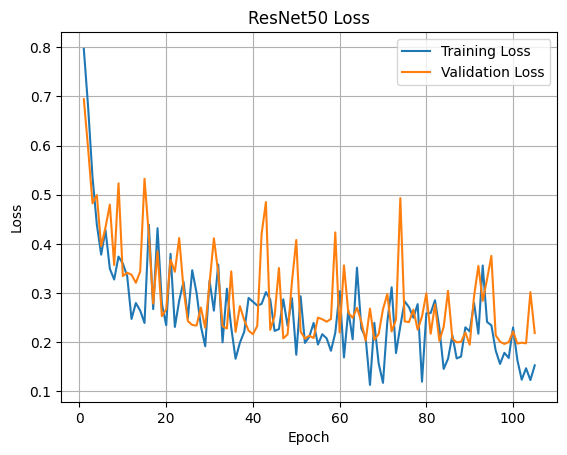

In [33]:
for layer in resnet_model.layers[-4:]:
    layer.trainable = True

early_stopping_tl_model = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True)

checkpoint_tl_model = tf.keras.callbacks.ModelCheckpoint(
    'pneumonia_classification_tl_model.keras', monitor='val_loss', save_best_only=True, verbose = 1)

resnet_model.fit(train_ds,
                    steps_per_epoch=len(train_names) // BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    validation_data=val_ds,
                    validation_steps=len(val_names) // BATCH_SIZE,
                    callbacks=[early_stopping_tl_model, checkpoint_tl_model, resnet_plotcallback],
                    verbose=0)

Now we see our model performance metrics:

I0000 00:00:1746975804.230569     804 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9289007270251842906), session_name()


I0000 00:00:1746975809.220200     804 tpu_compile_op_common.cc:245] Compilation of 9289007270251842906 with session name  took 4.989558877s and succeeded


I0000 00:00:1746975809.235091     804 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9289007270251842906), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_18293980001393332267", property.function_library_fingerprint = 11806291650192424679, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "14,224,224,3,;14,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1746975809.235123     804 tpu_compilation_cache_interface.cc:542] After adding entry for key 9289007270251842906 with session_name  cache is 8 entries (136552676 bytes),  marked for eviction 0 entries (0 bytes).


Loss,Accuracy,Precision,Recall,AUC,F1-Score
0.0939948,0.964786,0.961483,0.995268,0.992147,0.978084


I0000 00:00:1746975812.037480      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12801577584068997960


E0000 00:00:1746975812.191643      74 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_8_1/dense_3_1/BiasAdd/ReadVariableOp.


I0000 00:00:1746975812.604815     891 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(12920775759652836734), session_name()


I0000 00:00:1746975817.474629     891 tpu_compile_op_common.cc:245] Compilation of 12920775759652836734 with session name  took 4.869771928s and succeeded


I0000 00:00:1746975817.484457     891 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(12920775759652836734), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_12801577584068997960", property.function_library_fingerprint = 15727248148283388872, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1746975817.484494     891 tpu_compilation_cache_interface.cc:542] After adding entry for key 12920775759652836734 with session_name  cache is 9 entries (155968064 bytes),  marked for eviction 0 entries (0 bytes).


I0000 00:00:1746975820.381376      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6012297390122154837


I0000 00:00:1746975821.035436     831 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14389075768080363390), session_name()


I0000 00:00:1746975825.823169     831 tpu_compile_op_common.cc:245] Compilation of 14389075768080363390 with session name  took 4.787693448s and succeeded


I0000 00:00:1746975825.835101     831 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14389075768080363390), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_6012297390122154837", property.function_library_fingerprint = 985039618237066987, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "14,224,224,3,;14,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1746975825.835130     831 tpu_compilation_cache_interface.cc:542] After adding entry for key 14389075768080363390 with session_name  cache is 10 entries (175580962 bytes),  marked for eviction 0 entries (0 bytes).


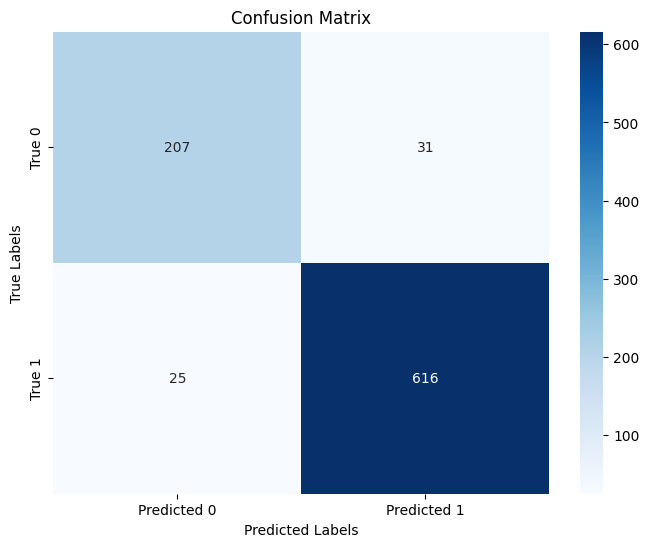

In [34]:
eval_and_plot_cf(resnet_model)

Lastly, we compare our custom model with the transfer learning model based on ResNet50.

In [35]:
def custom_vs_tl_table(data, names):
    headers = ['Model/Metric'] + list(data[0].keys())
    columns = {key: [d[key] for d in data] for key in data[0].keys()} 

    best_per_column = {
    key: min(values) if key.lower() == 'loss' else max(values)
    for key, values in columns.items()
    }

    rows = []
    for i, values in enumerate(data):
        row = [names[i]]
        for key in data[0].keys():
            val = values[key]
            if val == best_per_column[key]:
                row.append(f'<span style="color: #5DFF35;">{round(val,8)}</span>')
            else:
                row.append(round(val,8))
        rows.append(row)

    return HTML(tabulate(rows, headers=headers, tablefmt='unsafehtml'))


In [36]:
custom_vs_tl_table(metrics_history, ['Our model','ResNet50'])

Model/Metric,Loss,Accuracy,Precision,Recall,AUC,F1-Score
Our model,0.06411073,0.97536784,0.9886471,0.98005587,0.99584001,0.98433274
ResNet50,0.09399483,0.96478552,0.96148348,0.99526834,0.99214655,0.97808425


# Model interpretability

we use Local Interpretable Model-Agnostic Explanations (LIME), which highlights the parts of the image that the model focuses on to make a prediction. The code will display three example images. Dark areas represent areas that had little effect on the prediction, while other areas indicate parts of the image that had a higher impact.

In [37]:
!pip install lime -q


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:50, 19.44it/s]

  3%|▎         | 28/1000 [00:00<00:17, 54.31it/s]

  4%|▍         | 40/1000 [00:00<00:14, 64.40it/s]

  6%|▌         | 60/1000 [00:00<00:10, 86.48it/s]

  8%|▊         | 80/1000 [00:01<00:09, 101.55it/s]

 10%|█         | 100/1000 [00:01<00:08, 110.66it/s]

 12%|█▏        | 118/1000 [00:01<00:07, 125.65it/s]

 13%|█▎        | 133/1000 [00:01<00:07, 120.52it/s]

 15%|█▌        | 150/1000 [00:01<00:07, 117.73it/s]

 17%|█▋        | 170/1000 [00:01<00:06, 124.25it/s]

 19%|█▉        | 190/1000 [00:01<00:06, 128.68it/s]

 21%|██        | 208/1000 [00:01<00:05, 140.18it/s]

 22%|██▏       | 223/1000 [00:02<00:06, 129.33it/s]

 24%|██▍       | 240/1000 [00:02<00:06, 126.56it/s]

 26%|██▌       | 260/1000 [00:02<00:05, 130.55it/s]

 28%|██▊       | 280/1000 [00:02<00:05, 133.82it/s]

 30%|███       | 300/1000 [00:02<00:05, 133.35it/s]

 32%|███▏      | 320/1000 [00:02<00:05, 135.18it/s]

 34%|███▍      | 340/1000 [00:02<00:04, 138.16it/s]

 36%|███▌      | 360/1000 [00:03<00:04, 137.07it/s]

 38%|███▊      | 380/1000 [00:03<00:04, 139.43it/s]

 40%|████      | 400/1000 [00:03<00:04, 137.72it/s]

 42%|████▏     | 420/1000 [00:03<00:04, 136.47it/s]

 44%|████▍     | 439/1000 [00:03<00:03, 148.45it/s]

 46%|████▌     | 455/1000 [00:03<00:03, 138.09it/s]

 47%|████▋     | 470/1000 [00:03<00:04, 128.14it/s]

 49%|████▉     | 490/1000 [00:04<00:04, 125.37it/s]

 51%|█████     | 510/1000 [00:04<00:03, 130.35it/s]

 53%|█████▎    | 528/1000 [00:04<00:03, 141.67it/s]

 54%|█████▍    | 543/1000 [00:04<00:03, 132.60it/s]

 56%|█████▌    | 560/1000 [00:04<00:03, 129.51it/s]

 57%|█████▋    | 574/1000 [00:04<00:03, 120.29it/s]

 59%|█████▊    | 587/1000 [00:04<00:03, 117.51it/s]

 60%|██████    | 600/1000 [00:05<00:03, 110.92it/s]

 62%|██████▏   | 620/1000 [00:05<00:03, 120.95it/s]

 64%|██████▍   | 640/1000 [00:05<00:02, 128.26it/s]

 66%|██████▌   | 660/1000 [00:05<00:02, 125.01it/s]

 68%|██████▊   | 680/1000 [00:05<00:02, 130.84it/s]

 70%|███████   | 700/1000 [00:05<00:02, 134.80it/s]

 72%|███████▏  | 720/1000 [00:05<00:02, 136.50it/s]

 74%|███████▍  | 740/1000 [00:06<00:01, 138.00it/s]

 76%|███████▌  | 760/1000 [00:06<00:01, 140.34it/s]

 78%|███████▊  | 780/1000 [00:06<00:01, 139.71it/s]

 80%|████████  | 800/1000 [00:06<00:01, 141.57it/s]

 82%|████████▏ | 820/1000 [00:06<00:01, 140.70it/s]

 84%|████████▍ | 840/1000 [00:06<00:01, 142.64it/s]

 86%|████████▌ | 860/1000 [00:06<00:00, 143.03it/s]

 88%|████████▊ | 880/1000 [00:07<00:00, 138.54it/s]

 90%|█████████ | 900/1000 [00:07<00:00, 141.20it/s]

 92%|█████████▏| 920/1000 [00:07<00:00, 140.31it/s]

 94%|█████████▍| 940/1000 [00:07<00:00, 135.39it/s]

 96%|█████████▌| 960/1000 [00:07<00:00, 136.62it/s]

 98%|█████████▊| 980/1000 [00:07<00:00, 139.88it/s]

100%|██████████| 1000/1000 [00:07<00:00, 139.90it/s]

100%|██████████| 1000/1000 [00:07<00:00, 126.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 20/1000 [00:00<00:06, 140.35it/s]

  4%|▍         | 40/1000 [00:00<00:06, 138.70it/s]

  6%|▌         | 60/1000 [00:00<00:06, 136.45it/s]

  8%|▊         | 80/1000 [00:00<00:06, 138.05it/s]

  9%|▉         | 94/1000 [00:01<00:20, 44.31it/s] 

 11%|█         | 110/1000 [00:01<00:16, 55.61it/s]

 13%|█▎        | 128/1000 [00:01<00:12, 72.34it/s]

 14%|█▍        | 141/1000 [00:01<00:10, 78.20it/s]

 16%|█▌        | 160/1000 [00:01<00:09, 88.59it/s]

 18%|█▊        | 180/1000 [00:02<00:08, 101.61it/s]

 20%|██        | 200/1000 [00:02<00:07, 110.70it/s]

 22%|██▏       | 220/1000 [00:02<00:06, 120.30it/s]

 24%|██▍       | 240/1000 [00:02<00:05, 127.45it/s]

 26%|██▌       | 260/1000 [00:02<00:05, 129.08it/s]

 28%|██▊       | 275/1000 [00:02<00:05, 133.69it/s]

 29%|██▉       | 290/1000 [00:02<00:05, 127.90it/s]

 31%|███       | 310/1000 [00:03<00:05, 133.68it/s]

 33%|███▎      | 330/1000 [00:03<00:04, 136.12it/s]

 35%|███▌      | 350/1000 [00:03<00:04, 137.73it/s]

 37%|███▋      | 370/1000 [00:03<00:04, 138.11it/s]

 39%|███▉      | 390/1000 [00:03<00:04, 140.64it/s]

 41%|████      | 410/1000 [00:03<00:04, 140.47it/s]

 43%|████▎     | 430/1000 [00:03<00:04, 141.20it/s]

 45%|████▌     | 450/1000 [00:04<00:03, 143.11it/s]

 47%|████▋     | 470/1000 [00:04<00:03, 142.63it/s]

 49%|████▉     | 490/1000 [00:04<00:03, 140.97it/s]

 51%|█████     | 510/1000 [00:04<00:03, 143.31it/s]

 53%|█████▎    | 530/1000 [00:04<00:03, 143.56it/s]

 55%|█████▌    | 550/1000 [00:04<00:03, 142.84it/s]

 57%|█████▋    | 567/1000 [00:04<00:02, 148.58it/s]

 58%|█████▊    | 583/1000 [00:04<00:02, 141.37it/s]

 60%|██████    | 600/1000 [00:05<00:02, 137.38it/s]

 62%|██████▏   | 620/1000 [00:05<00:02, 135.68it/s]

 64%|██████▍   | 640/1000 [00:05<00:02, 132.88it/s]

 66%|██████▌   | 659/1000 [00:05<00:02, 145.66it/s]

 67%|██████▋   | 674/1000 [00:05<00:02, 136.94it/s]

 69%|██████▉   | 690/1000 [00:05<00:02, 124.49it/s]

 71%|███████   | 710/1000 [00:05<00:02, 132.79it/s]

 73%|███████▎  | 730/1000 [00:06<00:01, 135.20it/s]

 75%|███████▌  | 750/1000 [00:06<00:01, 140.82it/s]

 77%|███████▋  | 770/1000 [00:06<00:01, 143.64it/s]

 79%|███████▉  | 790/1000 [00:06<00:01, 145.07it/s]

 81%|████████  | 810/1000 [00:06<00:01, 144.01it/s]

 83%|████████▎ | 830/1000 [00:06<00:01, 146.39it/s]

 85%|████████▌ | 850/1000 [00:06<00:01, 142.60it/s]

 87%|████████▋ | 867/1000 [00:06<00:00, 148.82it/s]

 88%|████████▊ | 883/1000 [00:07<00:00, 140.97it/s]

 90%|█████████ | 900/1000 [00:07<00:00, 137.60it/s]

 92%|█████████▏| 920/1000 [00:07<00:00, 137.82it/s]

 94%|█████████▍| 940/1000 [00:07<00:00, 139.08it/s]

 96%|█████████▌| 960/1000 [00:07<00:00, 142.16it/s]

 98%|█████████▊| 980/1000 [00:07<00:00, 142.02it/s]

100%|██████████| 1000/1000 [00:07<00:00, 144.07it/s]

100%|██████████| 1000/1000 [00:07<00:00, 126.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 20/1000 [00:00<00:06, 152.75it/s]

  4%|▍         | 40/1000 [00:00<00:06, 146.50it/s]

  6%|▌         | 60/1000 [00:00<00:06, 146.48it/s]

  8%|▊         | 80/1000 [00:00<00:06, 147.60it/s]

 10%|█         | 100/1000 [00:00<00:06, 149.11it/s]

 12%|█▏        | 120/1000 [00:00<00:05, 149.16it/s]

 14%|█▍        | 140/1000 [00:00<00:05, 148.55it/s]

 16%|█▌        | 160/1000 [00:01<00:05, 148.73it/s]

 18%|█▊        | 180/1000 [00:01<00:05, 147.82it/s]

 20%|██        | 200/1000 [00:01<00:05, 148.04it/s]

 22%|██▏       | 220/1000 [00:01<00:05, 148.63it/s]

 24%|██▍       | 240/1000 [00:01<00:05, 147.70it/s]

 26%|██▌       | 260/1000 [00:01<00:05, 147.82it/s]

 28%|██▊       | 280/1000 [00:01<00:04, 146.90it/s]

 30%|███       | 300/1000 [00:02<00:04, 146.39it/s]

 32%|███▏      | 320/1000 [00:02<00:04, 145.42it/s]

 34%|███▍      | 340/1000 [00:02<00:04, 144.24it/s]

 36%|███▌      | 360/1000 [00:02<00:04, 145.66it/s]

 38%|███▊      | 380/1000 [00:02<00:04, 145.65it/s]

 40%|████      | 400/1000 [00:02<00:04, 147.23it/s]

 42%|████▏     | 420/1000 [00:02<00:03, 147.14it/s]

 44%|████▍     | 440/1000 [00:02<00:03, 146.46it/s]

 46%|████▌     | 460/1000 [00:03<00:03, 145.13it/s]

 48%|████▊     | 480/1000 [00:03<00:03, 145.69it/s]

 50%|█████     | 500/1000 [00:03<00:03, 137.95it/s]

 52%|█████▏    | 520/1000 [00:03<00:03, 137.00it/s]

 54%|█████▍    | 540/1000 [00:03<00:03, 136.68it/s]

 56%|█████▌    | 560/1000 [00:03<00:03, 137.81it/s]

 58%|█████▊    | 580/1000 [00:04<00:03, 139.18it/s]

 60%|██████    | 600/1000 [00:04<00:02, 139.34it/s]

 62%|██████▏   | 620/1000 [00:04<00:02, 142.82it/s]

 64%|██████▍   | 640/1000 [00:04<00:02, 144.66it/s]

 66%|██████▌   | 660/1000 [00:04<00:02, 146.12it/s]

 68%|██████▊   | 680/1000 [00:04<00:02, 147.79it/s]

 70%|███████   | 700/1000 [00:04<00:02, 146.69it/s]

 72%|███████▏  | 720/1000 [00:04<00:01, 145.64it/s]

 74%|███████▍  | 740/1000 [00:05<00:01, 147.20it/s]

 76%|███████▌  | 760/1000 [00:05<00:01, 144.11it/s]

 78%|███████▊  | 780/1000 [00:05<00:01, 141.07it/s]

 80%|████████  | 800/1000 [00:05<00:01, 140.59it/s]

 82%|████████▏ | 820/1000 [00:05<00:01, 142.69it/s]

 84%|████████▍ | 840/1000 [00:05<00:01, 145.07it/s]

 86%|████████▌ | 860/1000 [00:05<00:00, 144.01it/s]

 88%|████████▊ | 880/1000 [00:06<00:00, 141.21it/s]

 90%|█████████ | 900/1000 [00:06<00:00, 142.23it/s]

 92%|█████████▏| 920/1000 [00:06<00:00, 143.70it/s]

 94%|█████████▍| 940/1000 [00:06<00:00, 144.40it/s]

 96%|█████████▌| 960/1000 [00:06<00:00, 143.52it/s]

 98%|█████████▊| 980/1000 [00:06<00:00, 142.47it/s]

100%|██████████| 1000/1000 [00:06<00:00, 144.66it/s]

100%|██████████| 1000/1000 [00:06<00:00, 144.54it/s]

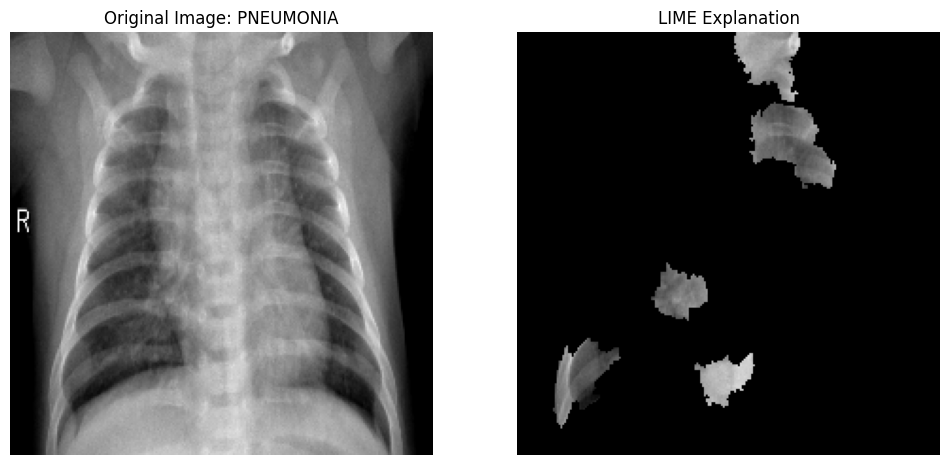

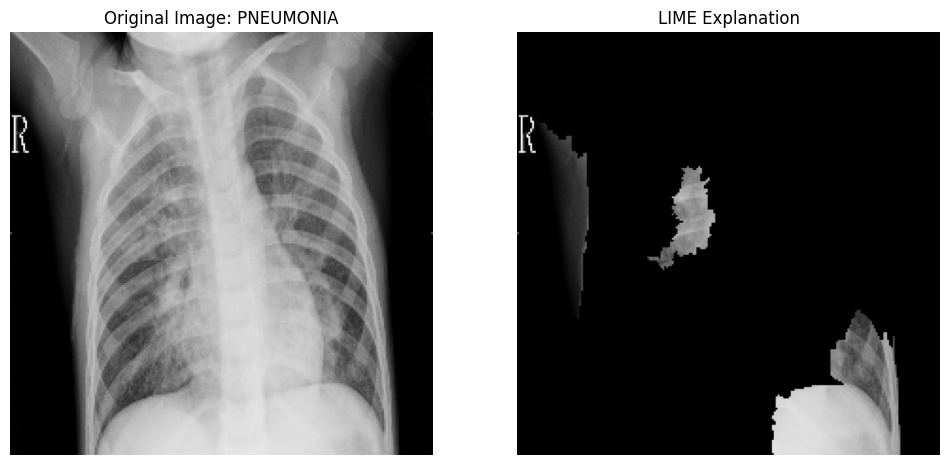

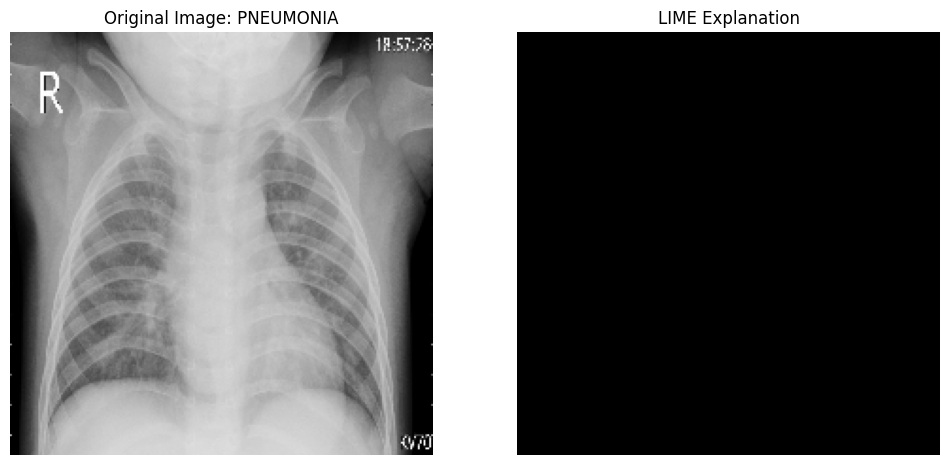

In [38]:
from lime import lime_image

@tf.function(reduce_retracing=True)
def predict_fn(images):
    images = tf.convert_to_tensor(images)
    if images.ndim == 3:
        images = tf.expand_dims(images, 0)
    return model(images)



explainer = lime_image.LimeImageExplainer()


for i in range(3):
  image = img_batch[i].numpy()
  explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  label = "PNEUMONIA" if label_batch[i] else "NORMAL"
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  ax1.imshow(image)
  ax1.set_title(f'Original Image: {label}')
  ax1.axis('off')

  ax2.imshow(temp)
  ax2.set_title('LIME Explanation')
  ax2.axis('off')

plt.show()

**Acknowledgment**: Parts of the code and workflow in this notebook were inspired by Amy Jang's Kaggle notebook: _[TensorFlow Pneumonia Classification on X-rays](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays)_. Proper credit is given to acknowledge their contribution and inspiration.